In [216]:
def normalize_weights(weights, tolerance=1e-9):
    # Check if weights already sum to approximately 1
    total = np.sum(weights)
    if abs(total - 1.0) < tolerance:
        return weights
        
    # Normalize weights
    normalized_weights = weights / total
    
    # Ensure exact sum to 1 by adjusting the largest weight
    sum_diff = 1.0 - np.sum(normalized_weights)
    if abs(sum_diff) > 0:
        max_idx = np.argmax(normalized_weights)
        normalized_weights[max_idx] += sum_diff
        
    # Verify the sum is now exactly 1.0
    assert abs(np.sum(normalized_weights) - 1.0) < tolerance
    
    return normalized_weights

In [294]:
import gurobipy as GRB
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from gurobipy import GRB, quicksum


def CVaR_optimization(bond_data, scenario_returns, benchmark_weight, alpha=0.95):
    S, N = scenario_returns.shape
    # Create the model
    model = gp.Model("CVaR_Bond_Optimization")

    model.setParam('OutputFlag', 0)

    # Decision variables
    w = model.addVars(N, vtype=GRB.CONTINUOUS, lb=0, name="w")  # weights for bonds
    x = model.addVars(N, vtype=GRB.BINARY, name="x")  # binary selection of bonds
    VaR = model.addVar(vtype=GRB.CONTINUOUS, name="VaR")  # Value at Risk variable
    z = model.addVars(S, vtype=GRB.CONTINUOUS, lb=0, name="z")  # Auxiliary for CVaR
    
    # Objective function: Minimize CVaR risk (USING S)
    model.setObjective(
        VaR + (1 / (S * (1 - alpha))) * gp.quicksum(z[s] for s in range(S)),
        GRB.MINIMIZE
    )
    
    # Constrain the total weight
    model.addConstr(gp.quicksum(w[i] for i in range(N)) >= 0.99 , "SumToOneLower")
    model.addConstr(gp.quicksum(w[i] for i in range(N)) <= 1, "SumToOneUpper")

    # Extract expected returns from the DataFrame
    expected_returns = bond_data["ExpectedReturn"].values  # Assuming "ExpectedReturns" is a column in the DataFrame

# Add constraint in the model
    #for i in range(N):
        #if expected_returns[i] < 0:
            #model.addConstr(x[i] == 0, f"ExcludeNegativeReturn_{i}")

# Coupling weights and binary variables: w[i] = 0 if x[i] = 0
    for i in range(N):
        model.addConstr(w[i] <= x[i], f"WeightCoupling_{i}")
    
# Create array of equal weights first
    weights = np.array([1/75] * 75)  # Creates array of 75 elements each with 1/75

# Normalize to ensure they sum to exactly 1
    normalized_weights = normalize_weights(weights)

# Now use the normalized weight as benchmark
    #BenchmarkWeight = normalized_weights[0]  # Since all weights are equal, can take any element

# Deviation from benchmark
    #deviation_limit = 1
    #epsilon = 1e-2  # small tolerance

    #for i in range(N):
        #model.addConstr(w[i] >= (BenchmarkWeight - deviation_limit*BenchmarkWeight) - epsilon, f"LowerBound_{i}")
        #model.addConstr(w[i] <= (BenchmarkWeight + deviation_limit*BenchmarkWeight) + epsilon, f"UpperBound_{i}")

    #VaR constraint
    
    model.addConstr(VaR >= gp.quicksum(w[i] * scenario_returns[s, i] for i in range(N) for s in range(S)) / S, "VaR_calculation")

    #CVaR constraint
    
    for s in range(S):  # Iterate through the scenarios
        model.addConstr(z[s] >= VaR - gp.quicksum(w[i] * scenario_returns[s, i] for i in range(N)), f"cvar_constraint_{s}")

    # Liquidity Constraint
    
    liquidity_scores = bond_data["LiquidityScore"].values
    avg_liquidity = np.mean(liquidity_scores)
    min_liquidity = 0 * avg_liquidity
    model.addConstr(
        gp.quicksum(liquidity_scores[i] * w[i] for i in range(N)) >= min_liquidity,
        "MinLiquidity"
    )

    weights = np.array([1 / N] * N)
    BenchmarkWeight = weights[0]  # Equal allocation for each bond

    # Deviation from benchmark
    deviation_limit = 0.4
    for i in range(N):
        model.addConstr(w[i] >= (BenchmarkWeight - deviation_limit * BenchmarkWeight), f"LowerBound_{i}")
        model.addConstr(w[i] <= (BenchmarkWeight + deviation_limit * BenchmarkWeight), f"UpperBound_{i}")



    # Optimize the model
    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        #print("Optimal solution found. List of all weights:")
        weights = [w[i].X for i in range(N)]  # Get the optimized weights for bonds
        return np.array(weights)

    if model.status == GRB.INFEASIBLE:
        print("The model is infeasible.")
        return None


In [219]:
import pandas as pd
import numpy as np
from scipy.stats import gmean
import sympy as sp

/var/folders/1b/p83v8krd07n4wstbm7mf_2_w0000gn/T/ipykernel_56978/2260870105.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'IsCouponDay'] = security_data['IsCouponDay']


Id
1     0.000040
2    -0.000194
3     0.000881
4    -0.001585
5     0.000000
        ...   
71    0.000000
72    0.006959
73   -0.003755
74    0.002025
75   -0.033149
Name: 2025-08-15 00:00:00, Length: 75, dtype: float64
2025-06-20 00:00:00
period returns:  [ 5.85970774e-03 -7.75576179e-03 -3.60105666e-03  1.65021424e-02
  7.42803367e-03  5.92035023e-03 -4.54983942e-03 -1.17081370e-02
  1.93190300e-02 -7.01850458e-03  4.38661132e-04  7.45397370e-03
  7.22285520e-03  1.04757353e-02  1.76670864e-02  6.79425901e-04
  4.59603871e-03  1.71958051e-02 -3.23181874e-03  2.30671586e-02
 -1.15490741e-02 -1.22037981e-02  7.70857764e-03  2.41959963e-02
  1.10975063e-02  9.22283505e-03  2.14692408e-02 -1.02735056e-02
  1.20391269e-02  1.20849425e-02 -8.35545032e-03  1.30996410e-02
  6.98886092e-03 -1.43458366e-04  1.74110401e-03  1.39949388e-03
 -5.09661599e-05  5.29255000e-03 -2.19198593e-03  9.88838868e-03
 -5.42948830e-03  4.54744625e-02  1.65804361e-03  1.55680625e-03
  1.03004112e-02 -1.330424

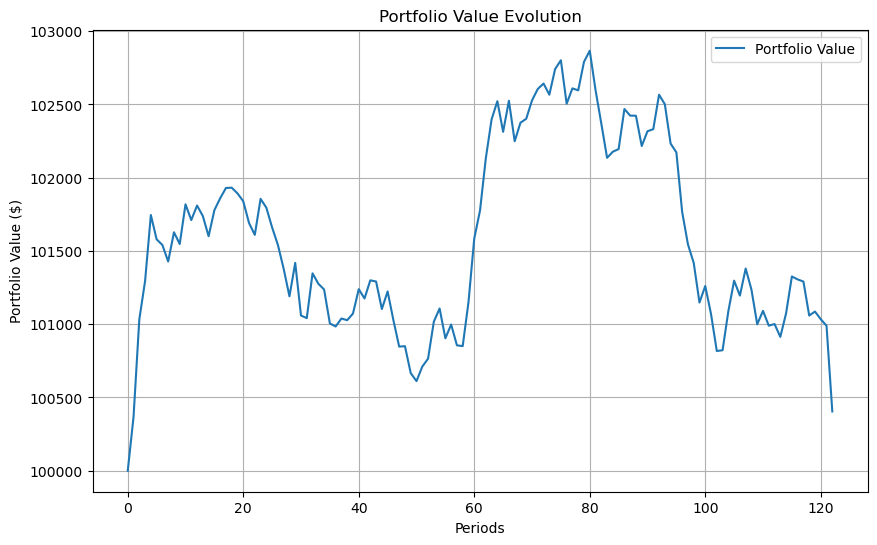

In [295]:
pd.set_option('mode.chained_assignment', None)
import numpy as np
from scipy.optimize import linprog
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gmean


def calculate_bond_returns(data):
    # Create a copy to avoid modifying original data
    df = data.copy()
    
    # Initialize returns column
    df['Returns'] = 0.0
    df['IsCouponDay'] = False
    
    # Extract numeric ID and ensure it's sorted
    df['Id'] = df['SecurityId'].str.extract(r'(\d+)').astype(int)
    df = df.sort_values(by=['Id'])  # Added Date to sorting
    
    for security in df['Id'].unique():
        # Create mask for current security
        mask = df['Id'] == security
        security_data = df[mask].copy()
        
        # Calculate previous day's values
        security_data['PrevDirtyPrice'] = security_data['DirtyPrice'].shift(1)
        security_data['PrevCleanPrice'] = security_data['CleanPrice'].shift(1)
        
        # Identify coupon days (when accrued interest is minimum for this security)
        min_accrued = security_data['AccruedInterest'].min()
        coupon_days = (security_data['AccruedInterest'] == min_accrued).astype(int)
        security_data['IsCouponDay'] = coupon_days
        
        # Calculate returns for coupon days
        coupon_returns = (
            (security_data['DirtyPrice'] - security_data['CleanPrice']) - 
            (security_data['PrevDirtyPrice'] - security_data['PrevCleanPrice'])
        ) / security_data['PrevDirtyPrice']
        
        # Calculate returns for non-coupon days
        price_returns = (
            security_data['DirtyPrice'] - security_data['PrevDirtyPrice']
        ) / security_data['PrevDirtyPrice']
        
        # Combine returns based on whether it's a coupon day
        security_data['Returns'] = np.where(coupon_days, coupon_returns, price_returns)
        
        # Update the main dataframe with calculated returns
        df.loc[mask, 'Returns'] = security_data['Returns']
        df.loc[mask, 'IsCouponDay'] = security_data['IsCouponDay']
    
    # Pivot the returns into a matrix
    returns_matrix = df.pivot(
        index='Date',
        columns='Id',
        values='Returns'
    )

    returns_matrix = returns_matrix.fillna(0)

    
    return returns_matrix

pd.set_option('mode.chained_assignment', None)
bond_data = pd.read_csv('bonds_w_exp_returns_final.csv')
bond_data['Date'] = pd.to_datetime(bond_data['Date'])
bond_data['DTS'] = bond_data['ModifiedDuration'] * bond_data['spread']
bond_data['transaction_cost'] = bond_data['BidAskSpread']
bond_data['OAS'] = pd.to_numeric(bond_data['spread'], errors='coerce')

returns_matrix = calculate_bond_returns(bond_data)

model = 'cVaR'
constraints = []
# Initial budget to invest ($100,000)
initialVal = 100000  

# Length of investment period 
investPeriod = 1

# Identify the tickers and the dates
tickers = bond_data['SecurityId'].unique()
dates = bond_data['Date'].unique()

n = len(tickers)   # Number of bonds
NoPeriods = len(dates) // investPeriod  

# Preallocate space for portfolio weights (x0 will track turnover)
x = np.zeros([n, NoPeriods])
x0 = np.zeros([n, NoPeriods])

lookback_window = 122  # Past 122 days
start_period = lookback_window // investPeriod  # Determine the first valid period

# Preallocate space for `currentVal` to match testing periods
currentVal = np.zeros(NoPeriods - start_period + 1)
currentVal[0] = initialVal  # Initialize with initial portfolio value

# Preallocate space for portfolio returns to match testing periods
portfolio_returns = np.zeros(NoPeriods - start_period)
turnover = np.zeros(NoPeriods - start_period)
transaction_costs = np.zeros(NoPeriods - start_period)

for i, period in enumerate(range(start_period, NoPeriods)):
    current_date = dates[period]  # The current day
    print(current_date)
    daily_real_return = returns_matrix.iloc[period].values
    print("period returns: ", daily_real_return)
    # Get the last 126 unique trading days (from the 'Date' column)
    end_date = current_date  # Current date is the last day
    start_date = dates[period - lookback_window]  # Start date is 126 days earlier

    # Filter data to only include the unique trading dates
    trading_days_in_range = bond_data[(bond_data['Date'] >= start_date) & (bond_data['Date'] <= end_date)]
    unique_trading_dates = trading_days_in_range['Date'].unique()

    if len(unique_trading_dates) < lookback_window:
        print(f"Skipping period {period}: not enough unique trading days.")
        continue
    
    # Use only the last 122 unique trading days
    last_122_trading_days = unique_trading_dates[-lookback_window:]

    # Filter the original data to keep only rows from the last 122 unique trading days
    rolling_window_data = bond_data[bond_data['Date'].isin(last_122_trading_days)]

    # Pivot to create a matrix of daily returns (rows: days, columns: bonds)
    daily_returns_matrix = rolling_window_data.pivot(index='Date', columns='SecurityId', values='ExpectedReturn')

    # Drop any columns (bonds) with missing data
    daily_returns_matrix = daily_returns_matrix.dropna(axis=1)

    # Check if there are enough scenarios (days) and bonds
    if daily_returns_matrix.shape[0] < lookback_window or daily_returns_matrix.shape[1] < len(tickers):
        print(f"Skipping period {period}: insufficient historical data for bonds.")
        continue

    current_bonds = bond_data[bond_data['Date'] == current_date]
    # Use the daily returns matrix as `scenario_returns`
    scenario_returns = daily_returns_matrix.values  # Convert to NumPy array
    weights = CVaR_optimization(bond_data, scenario_returns, 1/75, alpha=0.95)
    print(weights)

    if weights is None:
        print("Model returned nothing for weights")
        continue

    # Store weights for this period
    x[:, period] = weights
        
    # Portfolio calculations
    portfolio_return = np.sum(weights * daily_real_return)
    print("day: ", period, "return: ", portfolio_return)
    
    # Update `currentVal` using relative index `i`
    if not np.isnan(portfolio_return):  # Only update if the return is not NaN
        currentVal[i + 1] = currentVal[i] * (1 + portfolio_return)
    else:
        print(f"Skipping period {period}: missing data for portfolio return.")
    currentVal[i + 1] = currentVal[i] * (1 + portfolio_return)
    
    portfolio_returns[i] = portfolio_return

    # Turnover and transaction costs
    turnover_weights = np.abs(weights - x0[:, period])
    turnover[i] = np.sum(turnover_weights) / 2
    transaction_costs[i] = np.sum(turnover_weights * current_bonds['BidAskSpread'].values)

    # Deduct transaction costs from portfolio value
    currentVal[i + 1] -= transaction_costs[i]

    # Update `x0` for the next period
    x0[:, period] = weights

# Calculate Sharpe ratio
excess_returns = portfolio_returns
SR = (gmean(excess_returns + 1) - 1) / excess_returns.std()

# Average turnover and cumulative transaction costs
avgTurnover = np.mean(turnover)
total_transaction_cost = np.sum(transaction_costs)

print("currenval; ", currentVal)

print('Sharpe ratio: ', SR)
print('Avg. turnover: ', avgTurnover)
print('Total transaction costs: ', total_transaction_cost)

# Plot Portfolio Value Evolution
plt.figure(figsize=(10, 6))
plt.plot(range(len(currentVal)), currentVal, label='Portfolio Value')
plt.title('Portfolio Value Evolution')
plt.xlabel('Periods')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()
